# Standardising Australia Hazard Maps

The goal of this notebook is to develop and provide examples of mapping climate hazards for Australia so that data can be consistently presented.
Examples will include maps for Australia and for selected states or regions.

In [1]:
import datetime
datetime.datetime.today().date()

datetime.date(2024, 6, 11)

In [2]:
# this code is designed to work with hh5 analysis3-24.04 venv
import sys
print(sys.executable)

/g/data/hh5/public/./apps/cms_conda/envs/analysis3-24.04/bin/python


In [3]:
cd /g/data/mn51/users/gt3409/plotting_maps/

/g/data/mn51/users/gt3409/plotting_maps


# import packages used in this workflow


In [4]:
# import packages used in this workflow

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import seaborn as sns
import xarray as xr

# import colormap packages
import matplotlib.cm as cm
import cmaps
from matplotlib.colors import ListedColormap

# to plot cmaps
from pylab import *
from numpy import outer

from shapely.geometry import box

# define some standard imput for the maps
# crs = 'epsg:7844' #Australian centred
# crs = "epsg:3112" # "GDA 1994 Geoscience Australia Lambert"
# crs = "epsg:4460" # Australian Centre for Remote Sensing Lambert Conformal Projection
crs = 'epsg:3857' # mercator projection
xlim = (110,170)
ylim = (-45, -5)
logo = image.imread("ACS_Logo_Blue_on_white_Stacked.png")


# Suggested colormaps and scales

Using suggested colormaps and scales will improve the consistency across teams producing similar variables. This will support comparison across different plots.
- see many colormaps here: https://www.ncl.ucar.edu/Document/Graphics/color_table_gallery.shtml

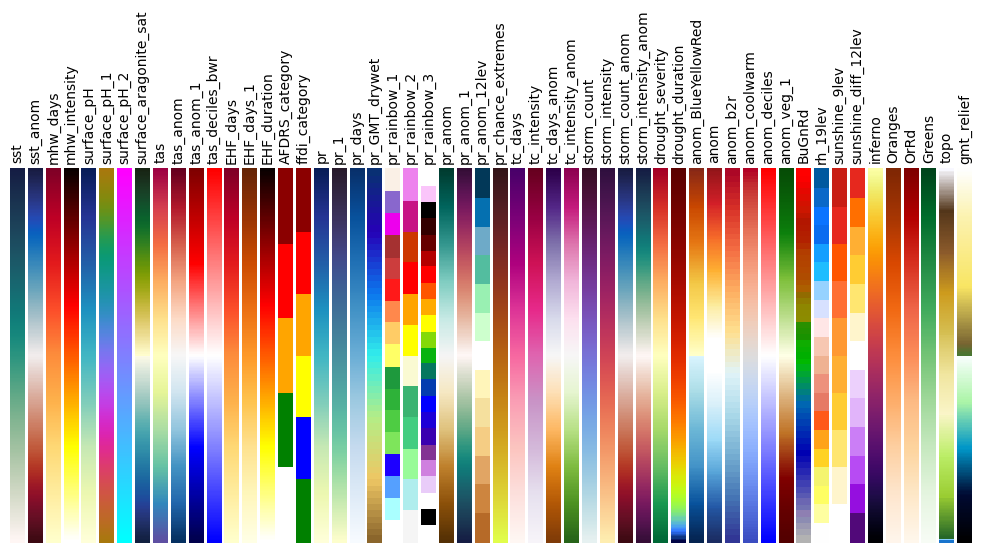

In [5]:
# This are a dictionary of suggested colormaps matched with possible variables to plot.  This includes color maps for total amount and for anomalies

cmap_dict = {"sst":cmaps.cmocean_tempo,
             "sst_anom": cmaps.cmocean_balance_r,
             "mhw_days": cm.YlOrRd,
             "mhw_intensity": cm.hot_r,
             "surface_pH":cm.YlGnBu,
             "surface_pH_1":cmaps.cmocean_phase,
             "surface_pH_2":cm.cool,
             "surface_aragonite_sat": cmaps.cmocean_delta,
             
             "tas":cm.Spectral_r,
             "tas_anom":cm.RdBu_r,
             "tas_anom_1":cm.seismic,
             "tas_deciles_bwr":cm.bwr,
             "EHF_days": cm.YlOrRd,
             "EHF_days_1": cm.YlOrBr,
             "EHF_duration":cm.hot_r,
             
             "AFDRS_category":ListedColormap(["white","green","orange", "red", "darkred"]),
             "ffdi_category":ListedColormap(["green", "blue", "yellow","orange", "red", "darkred"]),

             "pr":cm.YlGnBu,
             "pr_1":cmaps.cmocean_deep,
             "pr_days":cm.Blues,
             "pr_GMT_drywet": cmaps.GMT_drywet,
             "pr_rainbow_1":cmaps.prcp_1,
             "pr_rainbow_2":cmaps.prcp_2,
             "pr_rainbow_3":cmaps.prcp_3,         
             "pr_anom":cm.BrBG,
             "pr_anom_1":cmaps.cmocean_curl,
             "pr_anom_12lev":cmaps.precip_diff_12lev,
             "pr_chance_extremes": cmaps.cmocean_solar_r,
             
             "tc_days": cm.RdPu,
             "tc_intensity":cm.PuRd,
             "tc_days_anom":cm.PuOr,
             "tc_intensity_anom":cm.PiYG_r,

             "storm_count":cmaps.cmocean_dense,
             "storm_intensity":cmaps.cmocean_matter,
             "storm_count_anom":cmaps.cmocean_balance_r,
             "storm_intensity_anom": cmaps.cmocean_curl_r,
             
             "drought_severity": cm.RdYlGn_r,   
             "drought_duration":cmaps.hotres,
             
             "anom_BlueYellowRed":cmaps.BlueYellowRed,
             "anom":cmaps.BlueWhiteOrangeRed,
             "anom_b2r":cmaps.cmp_b2r,
             "anom_coolwarm":cmaps.MPL_coolwarm,
             "anom_deciles":cm.bwr,
             "anom_veg_1":cmaps.NEO_div_vegetation_a,          

             "BuGnRd":cmaps.temp1,

             "rh_19lev": cmaps.rh_19lev,
             "sunshine_9lev":cmaps.sunshine_9lev,
             "sunshine_diff_12lev":cmaps.sunshine_diff_12lev,
             "inferno":cm.inferno,
             "Oranges":cm.Oranges,
             "OrRd":cm.OrRd,
             "Greens": cm.Greens,

             "topo":cmaps.OceanLakeLandSnow,
             "gmt_relief":cmaps.GMT_relief,
            }

# show the colormaps in this dictionary
rc('text', usetex=False)
a=outer(arange(0,1,0.01),ones(10))
figure(figsize=(10,5))
subplots_adjust(top=0.8,bottom=0.05,left=0.01,right=0.99)
maps=[m for m in cmap_dict]
l=len(maps)+1
for i, m in enumerate(maps):
    subplot(1,l,i+1)
    axis("off")
    imshow(a,aspect='auto',cmap=cmap_dict[m],origin="lower")
    title(m,rotation=90,fontsize=10)
savefig("colormaps_aus_maps.png",dpi=100,facecolor='gray')

In [6]:
# This dictionary gives some sugeestions on the scale of the colour map to use for some variables. The scales are taken from cliamte maps on bom.gov.au/climate
tick_dict = {"pr_annual":  [0, 50, 100, 200, 300, 400, 600, 1000, 1500, 2000, 3000, 6000],
             "pr_6mon":    [0, 50, 100, 200, 300, 400, 600,  900, 1200, 1800, 2400, 6000],
             "pr_3mon":  [0, 10,  25,  50, 100, 200, 300,  400,  600,  800, 1200, 2500],
             "pr_mon" :  [0,  1,   5,  10,  25,  50, 100,  200,  300,  400,  600, 1200],
             "pr_days": [0, 2, 3, 5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175],
             "pr_anom_mon": [-1000, -400, -200, -100, -50, -25, -10, 0, 10, 25, 50, 100, 200, 400, 1000],
             "pr_anom_3mon": [-2000, -600, -400, -200, -100, -50, -25, 0, 25, 50, 100, 200, 400, 600, 2000],
             "pr_anom_6mon": [-3000, -1200, -800, -400, -200, -100, -50, 0, 50, 100, 200, 400, 800, 1200, 3000],
             "pr_anom_ann": [-4000, -1800, -1200, -800, -400, -200, -100, 0, 100, 200, 400, 800, 1200, 1800, 4000],
             "pr_diff_mon": [-1000, -400, -200, -100, -50, -25, -10, 10, 25, 50, 100, 200, 400, 1000],
             "pr_diff_ann": [-3000, -1800, -1200, -800, -400, -200, -100, 100, 200, 400, 800, 1200, 1800, 3000],
             "frost_days": [0, 10, 20, 30, 40, 50, 75, 100, 150, 300],
             "frost_days_mon":[0, 2, 5, 10, 15, 20, 25, 31],
             "tas": np.arange(-9,52, 3),
             "tas_anom_day": np.arange(-14, 14.1, 2),
             "tas_anom_mon": np.arange(-7, 7.1, 1),
             "tas_anom_ann": np.arange(-3.5, 3.6, 0.5),
             "apparent_tas": np.arange(-6, 42, 3),
             "percent": np.arange(0,101,10),
             
            }            
             

# Load the State and Region shape files

In [7]:
# write a dictionary of the shapefile geopandas dataframes. These will be used for state boundaries, LGAs, NRM, etc
gdf_dict = {}

shape_files = [ "aus_local_gov", "aus_states_territories", "australia", "nrm_regions", "river_regions"]
for name in shape_files:
    gdf_dict.update({name: gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp')})
gdf_dict.update({"broadacre_regions" : gpd.read_file('/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/broadacre_regions/aagis_asgs16v1_g5a.shp')})

    

In [8]:
# define a white mask for the area outside of Australian land
# We will use this to hide data outside of the Australian land borders. 
# note that this is not a data mask, the data under the masked area is still loaded and computed, but not visualised 

australia = gdf_dict["australia"]

# Define the CRS of the shapefile manually
australia.crs = crs

# This mask is a rectangular box around the maximum land extent of Australia with a buffer of 10 degrees on every side, with the Australian land area cut out so only the ocean is hidden.
not_australia = gpd.GeoSeries(data = [box(*box(*australia.total_bounds).buffer(15).bounds).difference(australia["geometry"].values[0])],
                              crs=crs,)


# Define single function for plotting maps

In [9]:
# this is the function you call to plot all the graphs
def plot_aus_shapefiles(name =  "aus_states_territories",
                        gdf = None,
                        data = None,
                        mask_not_australia = True,
                        facecolor = None, 
                        edgecolor = "black",
                        figsize = (8,6),
                        title = None,
                        date_range = "",
                        crs = crs,
                        area_linewidth = 0.3,
                        xlim = (110,170),
                        ylim = (-45, -5),
                        cmap = cm.Greens,
                        cbar_extent = "both",
                        ticks = None, 
                        cbar_label = "",
                        baseline = None,
                        dataset_name = None,
                        issued_date = None,                      
                        label_states = False,
                        contourf = True,
                        contour = True,
                        select_area = None,
                        land_shadow = False,
                        watermark = "EXPERIMENTAL IMAGE ONLY",
                        ):
    """This function takes a name of a Australian shapefile collection for data in /g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/ 
    and plots a map of Australia with the shape outlines. 
    
    gdf (geopandas.GeoDataFrame), if None, then will try to read from f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp'
    data expects a 2D xarray DataArray which has already computed the average, sum, anomaly, metric or index you wish to visualise. This function is resolution agnostic. 
    mask_not_australia is a boolean which decides whether or not the area outside of Australian land is hidden. Default is True.
    facecolor defines the color of land when you plot the regions without climate data. facecolor reccommendations include "white", "lightgrey", "none"
    edgecolor defines the color of the state/region borders. edgecolor reccommendations include "black" and "white"
    figsize defines the width and height of the figure in inches. Reccommend (8,6) for Australia wide plots and (6,6) for individual states etc.
    title defined the text inside the plot. If none is given, then will print the name of the shape file.
    date_range expects a string which describes the start and end data of the data analysed. This is printed under the title. format: dd Month yyyy to dd Month yyy
    crs defines the coordinate reference system. Similar to transform or projection.
    area_linewidth defines the width of state/region borders only. All other linewidths are hardcoded
    xlim and ylim define the extent of the plot area
    cmap defines the colormap used for the data. See cmap_dict for suggested colormaps. If none, cmap set to cm.Greens. Please choose appropriate colormap for your data.
    cbar_extent = "both" changes the ends of the colorbar to arrows to indicate that values are possible outside the scale show. If contour or contourf are True, then cbar_extent will be overridden to "none"
    ticks define the tick on the colorbar. Define any number of intervals. This will make the color for each interval one discrete color each, instead of a smooth color gradient.
    cbar_label defines the title for the color bar. This should indicate the variable name and the units eg "daily rainfall [mm]","annual rainfall [mm]", "monthly rainfall anomaly [mm]", "tas [\N{DEGREE SIGN}C]"
    baseline is a string to define the baseline period for anomalies, eg "1961-1990"
    dataset_name expects a string which describes the source of the data eg "AGCD v2" or "BARPA ACCESS-CM2"
    issued_date expects a string to describ ethe date of issue. If None is supplied, then today's date is printed.
    label_states (bool) if set to True and Australian states are the shapefile selected, then each state is labeled with its three letter abbreviation.
    contourf (bool) if True then the gridded data is visualised as smoothed filled countours. Default is True.
    contour (bool) if True then the gridded data is visualised as smoothed unfilled  grey countours. Default is True. Using both contourf and contour results in smooth filled countours with grey outlines between the color levels.
    select_area (list) expects a list of areas eg states which are in the geopandas.GeoDataFrame. Inspect the gdf for area names. eg ["Victoria", "New South Wales"]
    land_shadow (bool) used with select_area. This option controls whether show Australian land area that is outside the select area in grey for visual context.
    watermark (str) red text over plot for images not in their final form. If plot is in final form, set to None. Suggestions include "PRELIMINARY DATA", "DRAFT ONLY", "SAMPLE ONLY (NOT A FORECAST)", "EXPERIMENTAL IMAGE ONLY"

    The map is saved as a png in your working directory.
    This function returns fig and ax.    
    """
    if gdf is None:
        try:
            gdf = gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp')
        except:
            print(f"Could not read /g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp")
        
    # Define the CRS of the shapefile manually
    gdf.crs = crs

    # Set up the plot
    # sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=figsize, zorder=1, layout="constrained")
    
    if data is not None:
        facecolor = "none"
        
        if ticks is None:
            norm=None
        else:    
            norm = mpl.colors.BoundaryNorm(ticks, cmap.N)
        
        # plot the hazard data
        if contourf:
            plt.contourf(data.lon, data.lat, data, cmap = cmap, norm=norm, levels=ticks, extend = cbar_extent, zorder=2)
        else:
            plt.pcolormesh(data.lon, data.lat, data, cmap = cmap, norm=norm, zorder=2)
        cbar = plt.colorbar(extend = cbar_extent, cax=ax.inset_axes([0.85,0.2, 0.03, 0.6]), ticks=ticks, norm=norm,)
        cbar.ax.set_title(cbar_label, zorder=8, y=1.1, loc="center")
        if contour:
            cont = plt.contour(data.lon, data.lat, data, colors="grey", norm=norm, levels=ticks,extend = cbar_extent, linewidths=0.2, zorder=3)
            cbar.add_lines(cont)

        if mask_not_australia:
            # outside the shape, fill white
            not_australia.plot(ax=ax, facecolor="white", linewidth=0, zorder=5)

    if label_states and name=="aus_states_territories":
        # label the states with their name in the centre of the state
        states = ["WA", "NT", "SA", "QLD", "NSW", "VIC", "TAS"]
        lats = [-26.06, -19.7, -29.0, -24.2, -32.3, -37.1, -42.4]
        lons = [119.9, 133,  133, 143.6, 143.7, 142.0, 145.3]
        for lon, lat, state in zip(lons, lats, states):
            plt.text(lon, lat, state, size=12, zorder=10)
    
    gdf.plot(ax=ax,
             facecolor=facecolor,
             edgecolor=edgecolor, 
             linewidth=area_linewidth,
             zorder=4
            )

    # if select a specific area
    if select_area is None:
        plt.xlim(xlim)
        plt.ylim(ylim)
    else:
        assert isinstance(select_area, list), "select_area must be a list"
        # select state
        name_column = [name for name in gdf.columns if 'NAME' in name.upper()][0]
        area =gdf.loc[gdf[name_column].isin(select_area)] 
        map_total_bounds = area.total_bounds
        minx, miny, maxx, maxy = map_total_bounds
        mid_x = (minx+maxx)/2
        mid_y = (miny+maxy)/2
        max_range = np.max([(maxy-miny), (maxx-minx)])
        buffer=0.1*max_range
        
        not_area =  gpd.GeoSeries(data = [box(*box(*map_total_bounds).buffer(10*buffer).bounds).difference(area.dissolve()["geometry"].values[0])],
                                      crs=crs, )

        # mask outside selected area
        if land_shadow:
            # show land as light grey
            not_area.plot(ax=ax, facecolor="lightgrey", linewidth=0, zorder = 4)
        else:
            # mask white
            not_area.plot(ax=ax, facecolor="white", linewidth=0, zorder = 4)
               
        plt.xlim(mid_x - 0.6*max_range, mid_x + 0.8*max_range)
        plt.ylim(mid_y - 0.7*max_range, mid_y + 0.7*max_range)      
        
    
    # Set the plot title and axis labels
    if title is None:
        title = f"{data.name} {name}"

    ax = plt.gca()
    ax.text(0.1,0.06,f"{title.title()}\n{date_range}",
            fontsize = "large",
            horizontalalignment='left',
            transform=ax.transAxes,
            zorder=10)

    if baseline is not None:
        # print base period inside bottom left corner
        ax.text(x=0.01, y=0.01, s= f"Base period: {baseline}", fontsize=6, transform=ax.transAxes, zorder = 10)
    # print copyright outside bottom left corner
    ax.text(x=0.01, y=-0.03, s= f"\u00A9 Commonwealth of Australia {datetime.datetime.now().year}, Australian Climate Service",
            fontsize=6, transform=ax.transAxes, zorder = 10)
    # print data source inside bottom right
    ax.text(x=0.99, y=0.01, s= f"Dataset: {dataset_name}", fontsize=6, transform=ax.transAxes, horizontalalignment="right", zorder = 10)
    # print issued date on bottom right under the border. Set to today's date if None supplied
    if issued_date is None:
        issued_date = datetime.datetime.today().date().strftime('%d %B %Y')
    ax.text(x=0.99, y=-0.03, s= f"Issued: {issued_date}", fontsize=6, transform=ax.transAxes, horizontalalignment="right", zorder = 10)

    if watermark is not None:
         ax.text(x=0.5, y=0.5, s=watermark.upper(), 
                 fontsize=42,
                 transform=ax.transAxes,
                 horizontalalignment="center",
                 verticalalignment = "center",
                 zorder = 10, 
                 wrap=True,
                alpha = 0.5,
                color='r')

    # remove any lat lon labels and ticks
    plt.xlabel('')
    plt.ylabel('')
    plt.tick_params(axis="both", which = "both", bottom =False, left=False, labelbottom = False, labelleft=False)

    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth(2)
    
    # Place logo in top left
    ax.imshow(logo, extent=(0.0, 0.4*(figsize[1]/figsize[0]), 0.85, 1.0),  transform=ax.transAxes, zorder = 10) 
    
    fig.set_figheight(figsize[1])
    fig.set_figwidth(figsize[0])

    plt.savefig(f"{title.replace(' ', '_')}.png",)
    return fig, ax

# Example plots

## Example 1: Australia map only
These plots show the state/ region borders without data

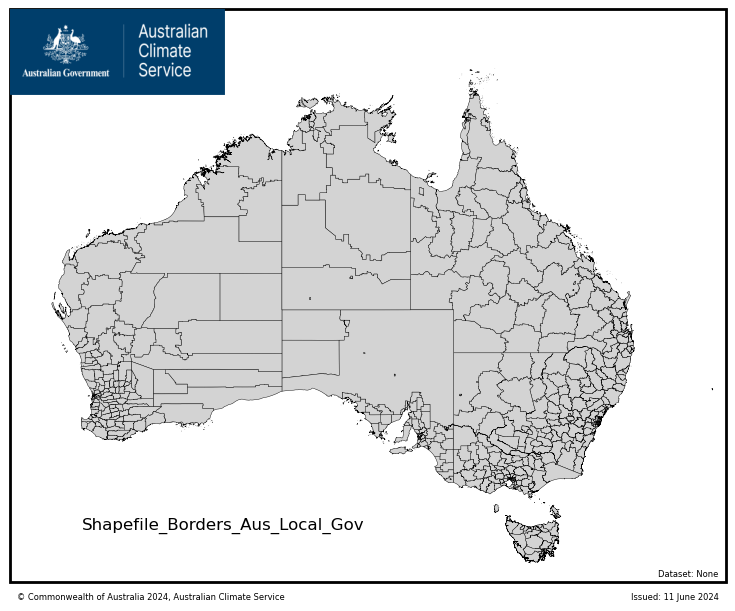

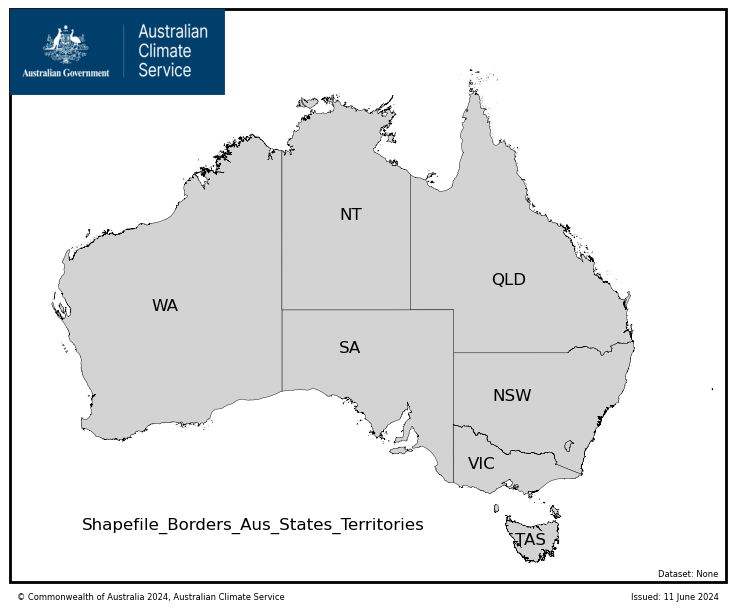

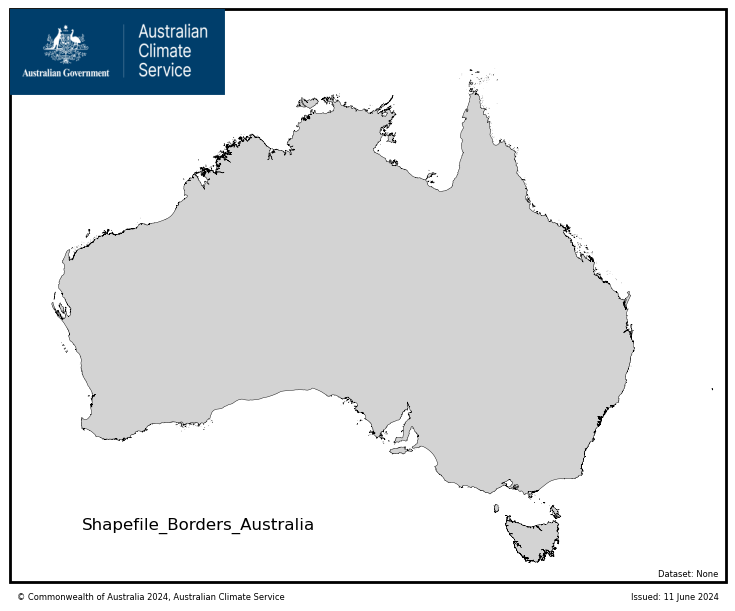

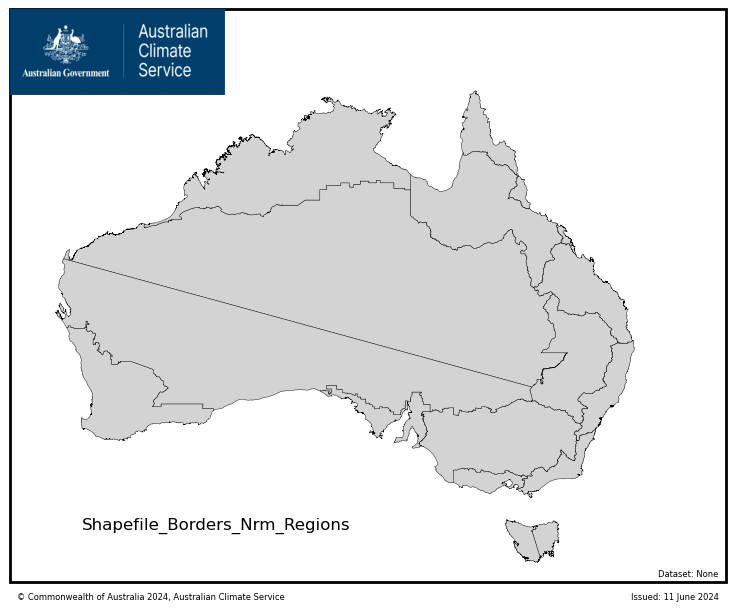

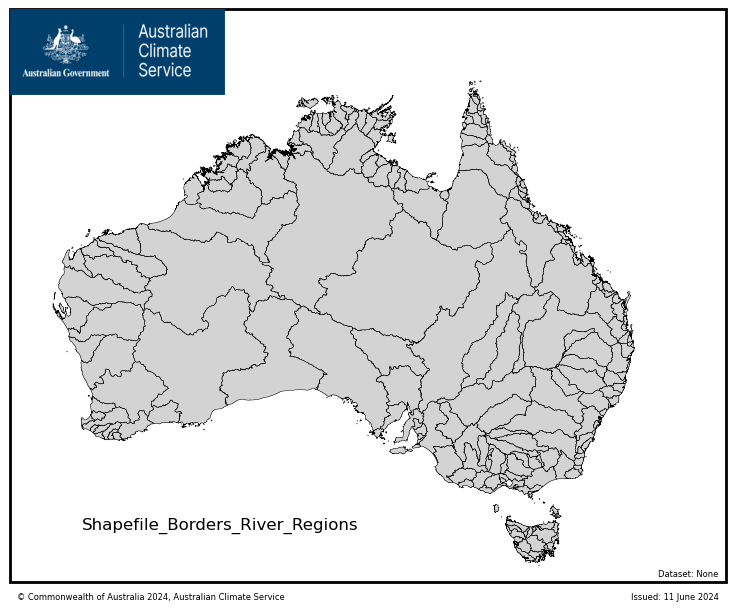

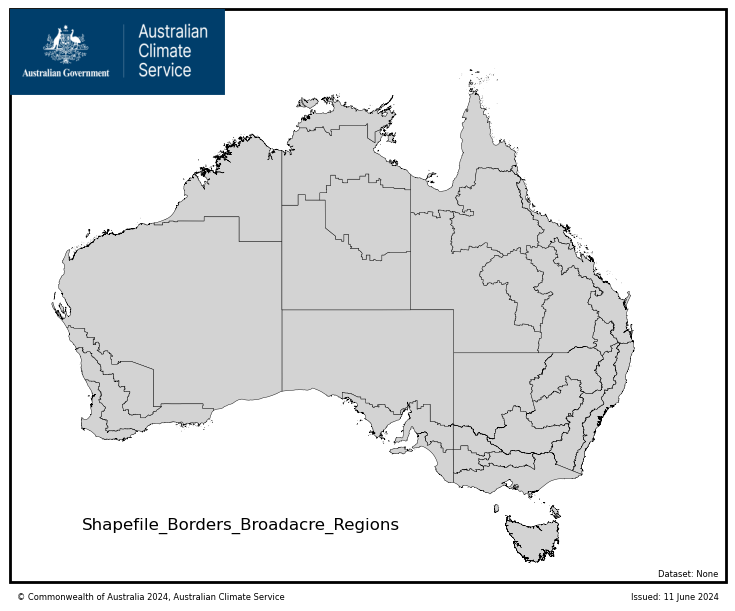

In [10]:
# Plot the shapefiles to see the borders

facecolor = "lightgrey"
xlim = (110,160)
ylim = (-45, -5)

for name in gdf_dict.keys():
    
    plot_aus_shapefiles(name = name,
                        gdf = gdf_dict[name],
                        facecolor = facecolor, 
                        xlim = xlim,
                        ylim = ylim,
                        label_states = True,
                        title=f"shapefile_borders_{name}",
                        watermark=None);


## Examples with data
Load some temperature and rainfall data

In [11]:
# Load some hazard data

In [12]:
# load some rainfall data
ds_pr = xr.open_dataset("/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/bias-adjustment-input/AGCD-05i/BOM/ACCESS-CM2/ssp370/r4i1p1f1/BARPA-R/v1-r1/day/pr/pr_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_BARPA-R_v1-r1_day_201501-201512.nc")
# annual total rainfall
da_pr_ann = ds_pr.sum(dim="time").pr
# rainfall for one month
da_pr_jan = ds_pr.sel(time = ds_pr.time.dt.month==1).sum(dim="time").pr
# rainfall anomaly for one month
da_pr_anom = da_pr_jan-da_pr_ann/12


In [13]:
# load some temperature data
ds_tasmax = xr.open_dataset("/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/bias-adjustment-input/AGCD-05i/BOM/ACCESS-CM2/ssp370/r4i1p1f1/BARPA-R/v1-r1/day/tasmax/tasmax_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_BARPA-R_v1-r1_day_201501-201512.nc")
da_tasmax = ds_tasmax.tasmax.max(dim="time")
da_tasmax_anom = ds_tasmax.tasmax.max(dim="time") - ds_tasmax.tasmax.mean(dim="time")

## Example 2: Australia plots with data

State lines on Australia, with rainfall and temperature data

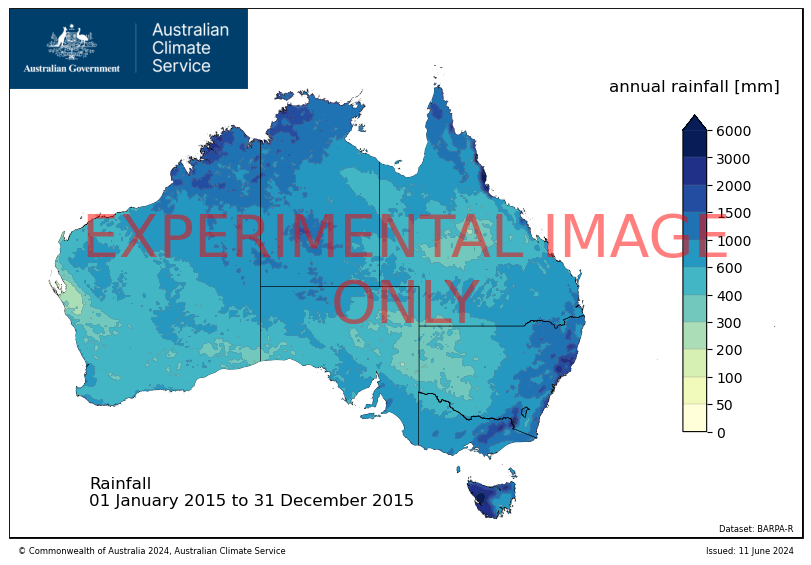

In [14]:
# Annual cummulative Rainfall

start = datetime.datetime.strptime(ds_pr.time_coverage_start, '%Y%m%dT%H%MZ').strftime("%d %B %Y")
end = datetime.datetime.strptime(ds_pr.time_coverage_end, '%Y%m%dT%H%MZ').strftime("%d %B %Y")

plot_aus_shapefiles(data = da_pr_ann,
                    gdf = gdf_dict['aus_states_territories'],
                   cmap=cmap_dict["pr"],
                   ticks=tick_dict['pr_annual'],
                   cbar_label="annual rainfall [mm]",
                   cbar_extent="max",
                    title = "Rainfall",
                   dataset_name = ds_pr.source_id,
                   date_range=f"{start} to {end}");

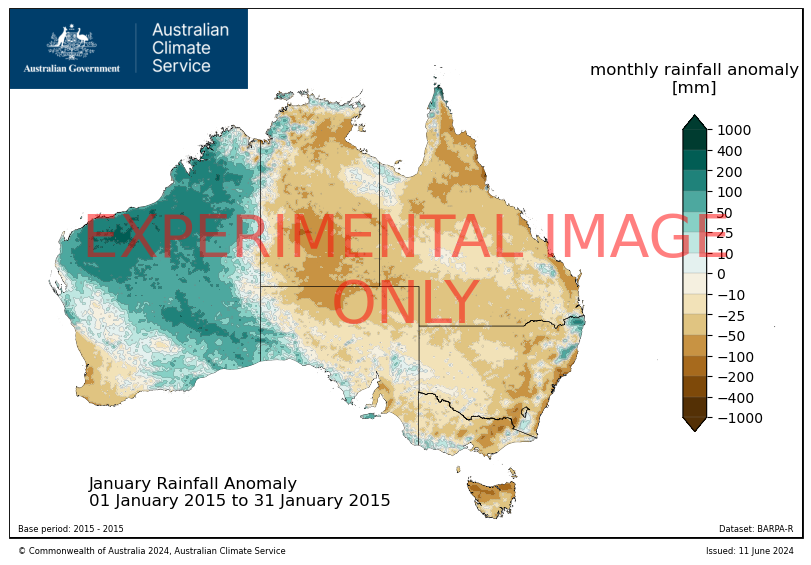

In [15]:
# Rainfall anomaly data

plot_aus_shapefiles(data = da_pr_anom,
                    gdf = gdf_dict['aus_states_territories'],
                   cmap=cmap_dict["pr_anom"],
                   ticks=tick_dict['pr_anom_mon'],
                   cbar_label="monthly rainfall anomaly\n[mm]",
                   title="January rainfall anomaly",
                   date_range=f"01 January 2015 to 31 January 2015",
                   baseline= "2015 - 2015",
                   dataset_name=ds_pr.source_id,
                    );

In [16]:
# Temperature plots for Australia. Notice that the colorbar stays the same even though the plotted temperature ranges are different

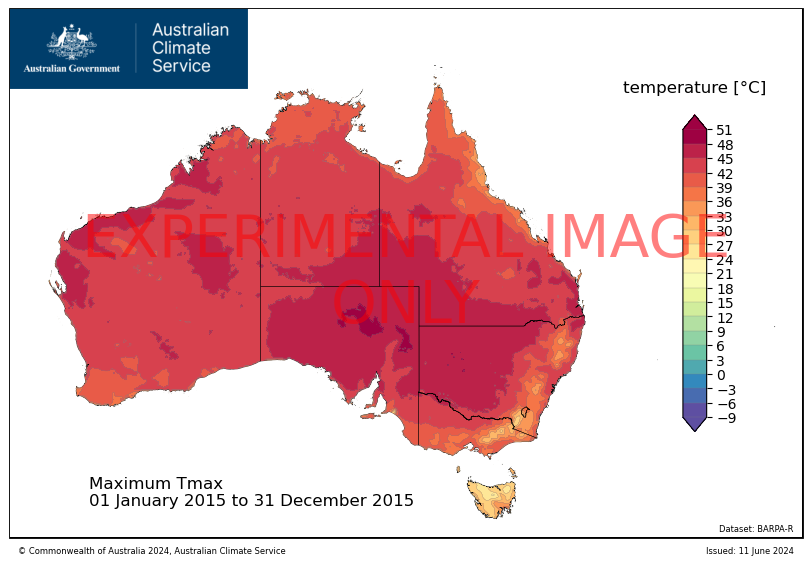

In [17]:
da_tasmax_max = ds_tasmax.tasmax.max(dim="time")

start = datetime.datetime.strptime(ds_tasmax.time_coverage_start, '%Y%m%dT%H%MZ').strftime("%d %B %Y")
end = datetime.datetime.strptime(ds_tasmax.time_coverage_end, '%Y%m%dT%H%MZ').strftime("%d %B %Y")

plot_aus_shapefiles(data = da_tasmax_max,
                    gdf = gdf_dict['aus_states_territories'],
                   cmap=cmap_dict["tas"],
                   ticks=tick_dict['tas'],
                    cbar_label="temperature [\N{DEGREE SIGN}C]",
                    title = "Maximum Tmax",
                    date_range=f"{start} to {end}",
                    dataset_name=ds_tasmax.source_id,
                   );

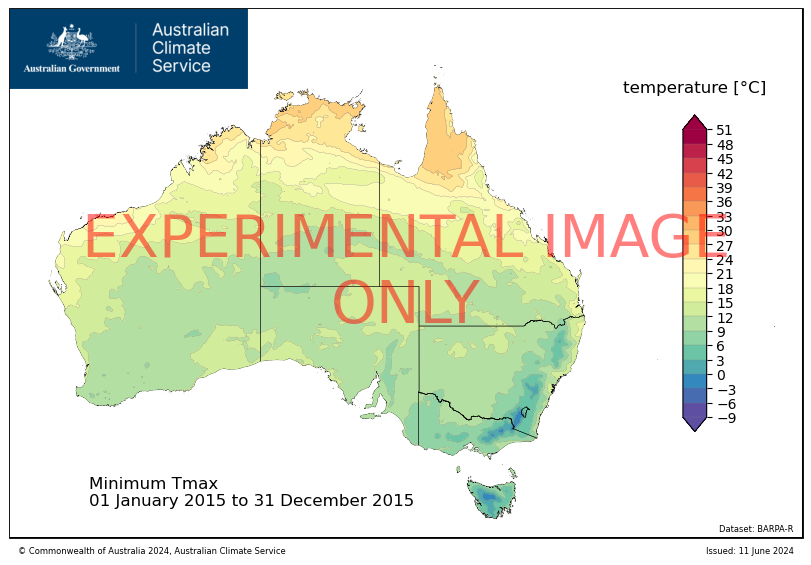

In [18]:
da_tasmax_min = ds_tasmax.tasmax.min(dim="time", keep_attrs=True)

start = datetime.datetime.strptime(ds_tasmax.time_coverage_start, '%Y%m%dT%H%MZ').strftime("%d %B %Y")
end = datetime.datetime.strptime(ds_tasmax.time_coverage_end, '%Y%m%dT%H%MZ').strftime("%d %B %Y")

plot_aus_shapefiles(data = da_tasmax_min,
                    gdf = gdf_dict['aus_states_territories'],
                   cmap=cmap_dict["tas"],
                   ticks=tick_dict['tas'],
                    cbar_label="temperature [\N{DEGREE SIGN}C]",
                    title = "Minimum Tmax",
                    date_range=f"{start} to {end}",
                    dataset_name=ds_tasmax.source_id,
                   );

## Example 3: Select areas
Plot data for selected areas/ states

In [19]:
# plot one state

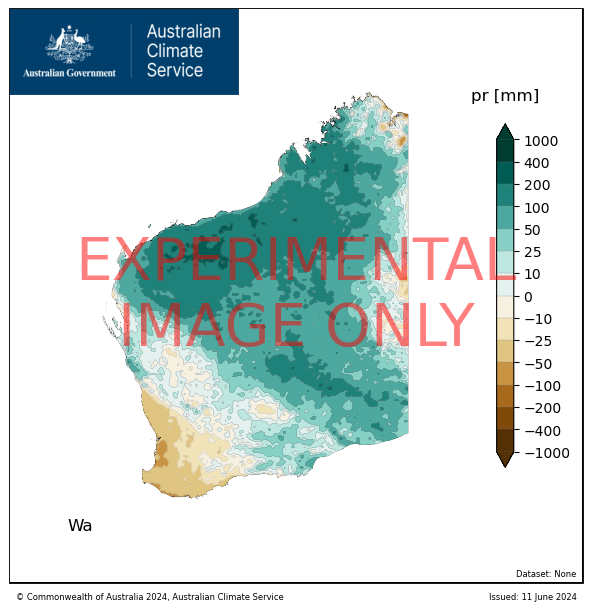

In [20]:
plot_aus_shapefiles(data = da_pr_anom,
                    gdf = gdf_dict['aus_states_territories'],
                   cmap=cmap_dict["pr_anom"],
                   ticks=tick_dict['pr_anom_mon'],
                   cbar_label="pr [mm]",
                   select_area=["Western Australia"],
                   figsize=(6,6),
                   title="WA", 
                   );

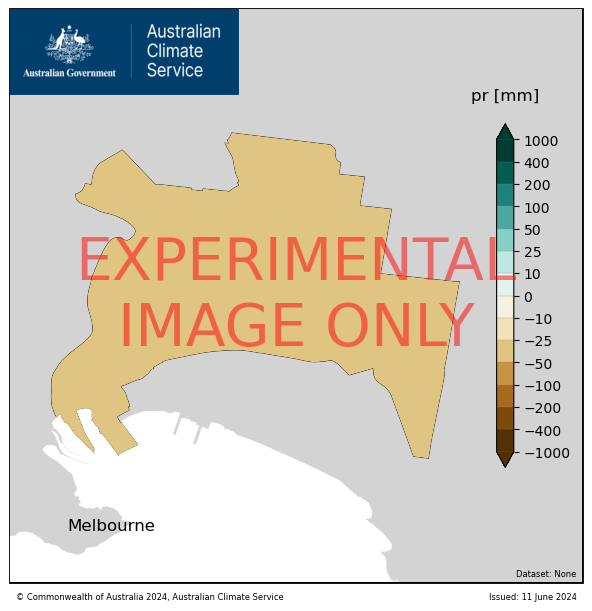

In [21]:
# Make sure that the gdf is the right one for the desired areas
plot_aus_shapefiles(data = da_pr_anom,
                    gdf = gdf_dict['aus_local_gov'],
                   cmap=cmap_dict["pr_anom"],
                   ticks=tick_dict['pr_anom_mon'],
                   cbar_label="pr [mm]",
                   select_area=["Melbourne"],
                   figsize=(6,6),
                   title="Melbourne",
                   land_shadow=True);

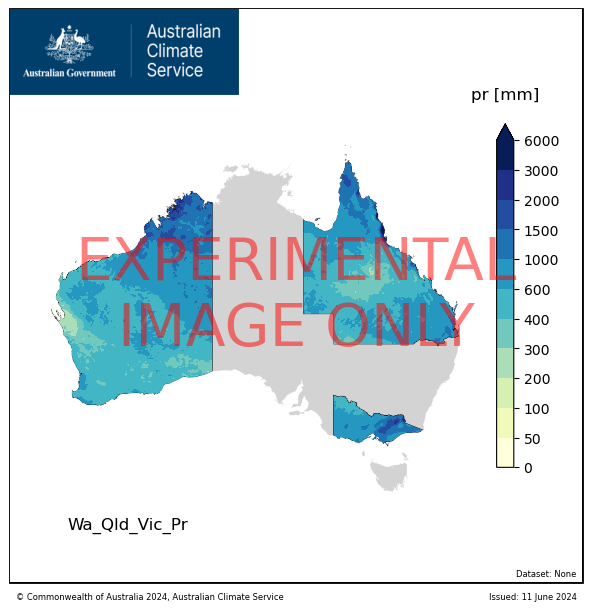

In [22]:
# select multiple non contiguous areas and show the area of non-selected australian land

fig, ax = plot_aus_shapefiles(data = da_pr_ann,
                              gdf = gdf_dict['aus_states_territories'],
                              cmap=cmap_dict["pr"],
                              cbar_label="pr [mm]",
                              ticks=tick_dict['pr_annual'],
                              cbar_extent="max",
                              select_area=["Victoria", "Western Australia", "Queensland"],
                              contourf=False,
                              figsize=(6,6),
                              contour=False,
                             land_shadow=True,
                             title = "WA_QLD_VIC_pr")


## Example 4: loop over areas to select and plot

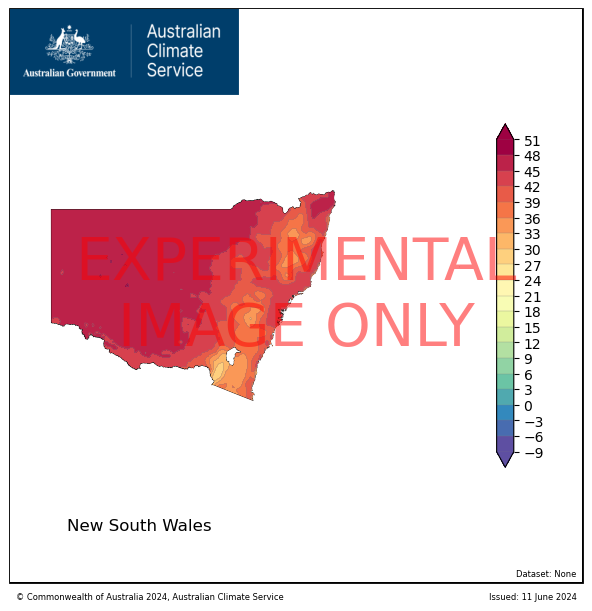

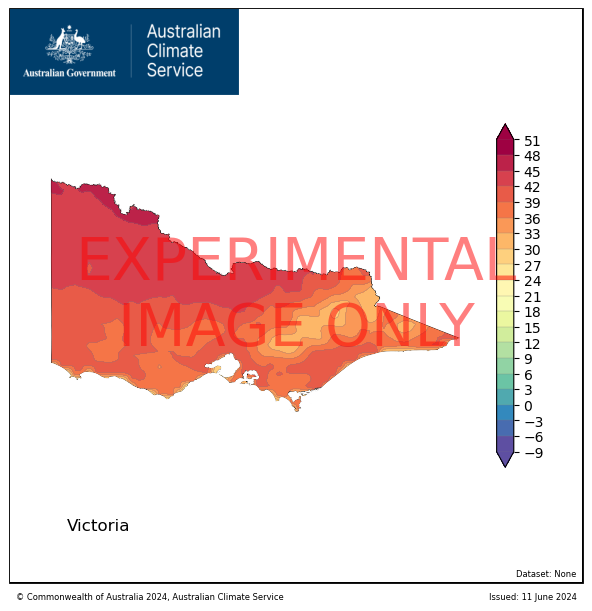

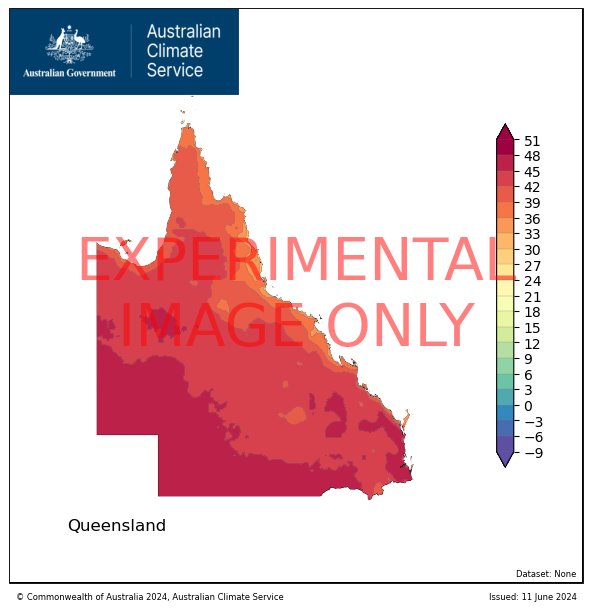

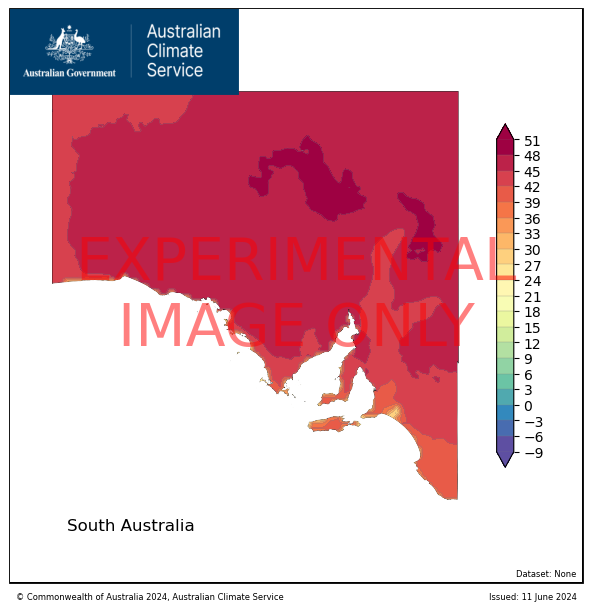

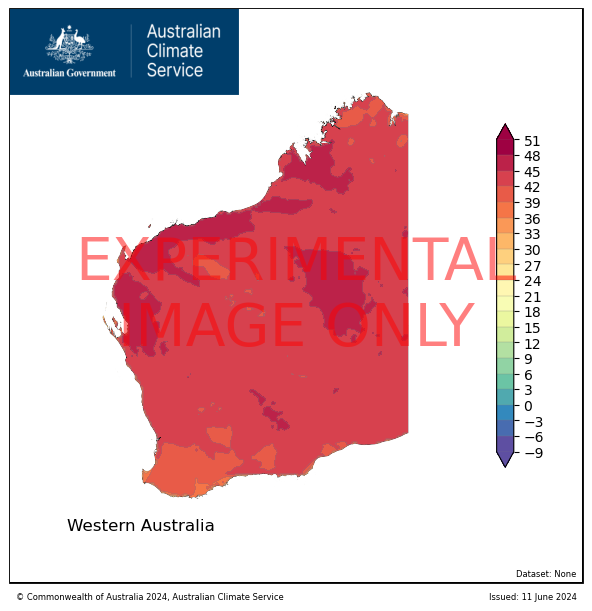

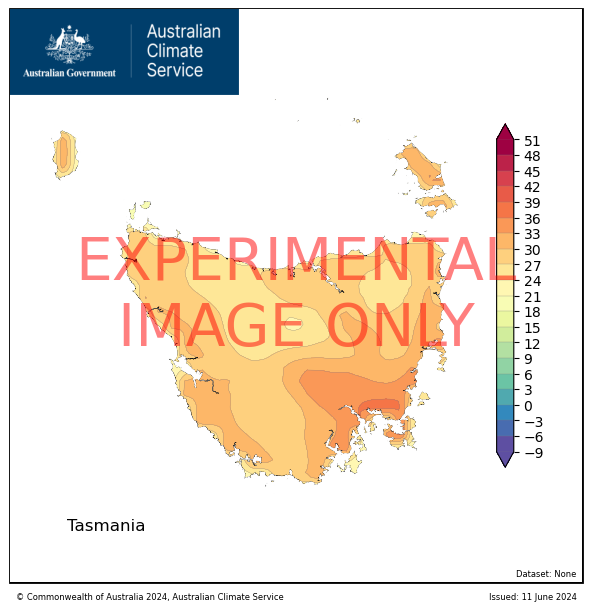

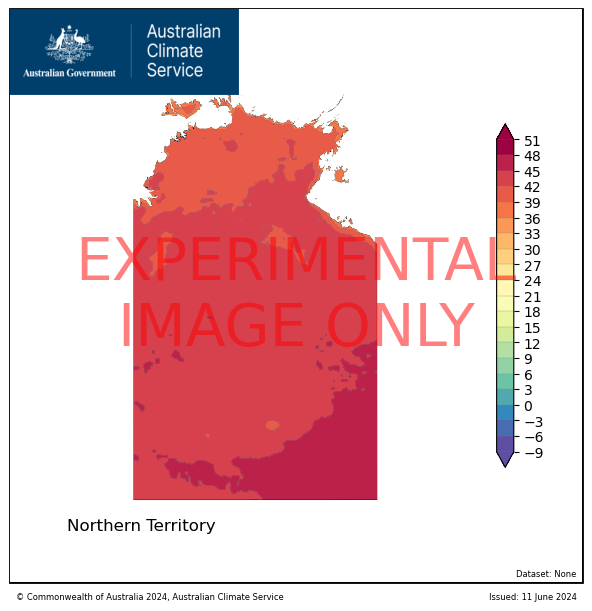

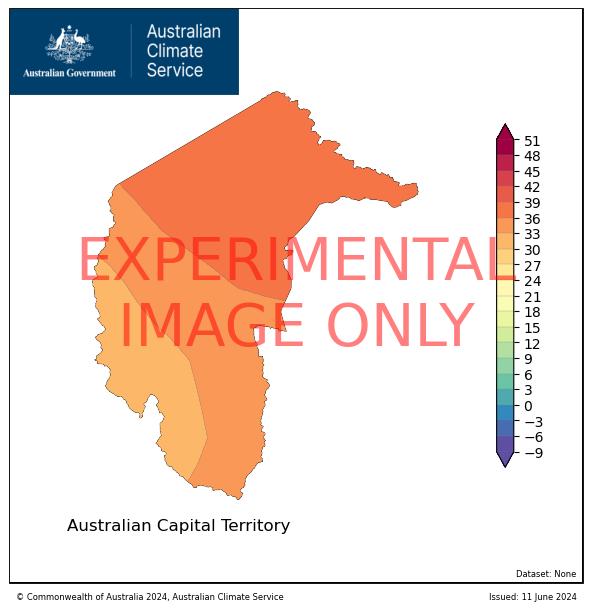

In [24]:
# loop over list of areas to cut out and make plots
gdf = gdf_dict['aus_states_territories']

for state in list(gdf.STE_NAME21)[:-1]:
    plot_aus_shapefiles(data = da_tasmax_max,
                        figsize=(6,6),
                        gdf = gdf,
                       cmap=cmap_dict["tas"],
                       ticks=tick_dict['tas'],
                       contour=True,
                       select_area=[state],
                       title=state);